In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

- Edge Detection Filters comparison : https://www.theobjects.com/dragonfly/dfhelp/30/Content/07_Image%20Processing/Edge%20Detection%20Filters.htm
- 이미지 그라디언트 연산자로 엣지 검출하기 : https://bskyvision.com/402

# 이미지 그라디언트 (Image Gradients)
    그라디언트(Gradient)는 기울기, 증감, 변화도, 즉 변화하는 정도를 나타내는 단어이다. 이미지 내에서 픽셀값의 변화가 가장 큰 부분은 일반적으로 경계선(edge) 및 모서리(corner)부분일 것이다. 따라서 Image Processing에서는 이를 잘 이용하여 영상의 경계선(edge) 및 그 방향을 찾는 용도로 활용된다. 
    
    
## Edge Detection
    변화하는 정도는 수학적으로 미분과 관련이 깊다. 이미지는 2차원이기 때문에 수직 방향과 수평 방향으로 미분해주면 수직 방향으로 어떻게 변화하는지, 또는 수평 방향으로 어떻게 변화하는지 알 수 있다. 그래서 이미지 (x, y)에서의 벡터값(Gradient의 크기, Gradient의 방향)을 구해 해당 픽셀에서 경계선까지 얼마나 가까운지, 그리고 그 방향이 어디인지 쉽게 알 수 있게 한다. 하지만 이미지는 연속이 아닌 이산된 데이터가 나열되어 있는 것이기 때문에 미분 연산을 할 수 없으므로 대신 인접한 화소끼리의 차이를 구하는 연산으로 근사한다. 이를 커널로 만들어 원본 이미지와 Convolution(합성곱)하는 것으로 경계선을 탐지한다.
    
    G_x = f(x+1, y) - f(x, y), dx = 1 (수직선 경계 탐지)
    G_y = f(x, y+1) - f(x, y), dy = 1 (수평선 경계 탐지)
    G[f(x, y)] ≒ √(G_x)^2 + (G_y)^2 (크기)
    a(x, y) = tan^(-1) (G_y / G_x) (방향)
    
    위의 미분 수식을 행렬로 나타내면 다음과 같다.
    G_x = [[-1, 0, 1]]
    G_y = [[-1], [0], [1]]
    위 필터는 기본적인 1차 미분 필터이며 이를 사용하여 이미지와 컨볼루션하면 경계선이 검출 된다.
    
    이런식으로 쭉 나열된 픽셀이 있고 x축 방향으로 픽셀들을 서로 비교해가면 x축으로 비교했을 때 픽셀들이 서로 맞닿아 있는 부분은 세로 축이므로 수직선에 대한 경계를 탐지할 수 있고, y축으로 비교했을 때 픽셀들이 서로 맞닿아 있는 부분은 가로 축이므로 수평선에 대한 경계를 탐지할 수 있다. 다만 해당 픽셀들의 밝기 변화가 얼마나 큰지, 필터 어느 부분에 가중치를 두었는지에 따라 경계선을 간결하지만 선명하게, 복잡하지만 자세하게 나타낼 수 있다.

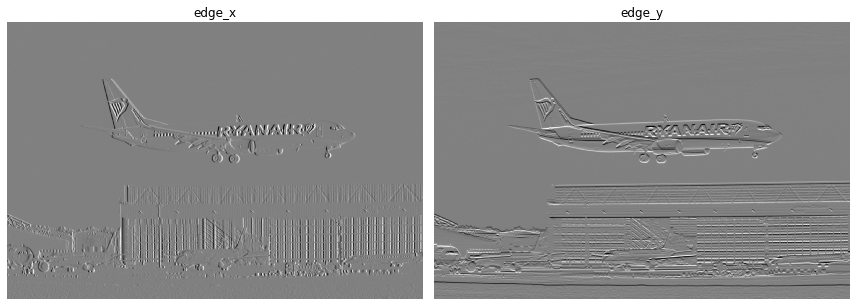

In [11]:
image = cv2.imread('ryanair-5249631_1920.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (11, 11), 0)

G_x = np.array([[-1, 0, 1]])
G_y = np.array([[-1], [0], [1]])

edge_x = cv2.filter2D(image, cv2.CV_64F, G_x)
edge_y = cv2.filter2D(image, cv2.CV_64F, G_y)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(edge_x, cmap = 'gray')
plt.title('edge_x')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edge_y, cmap = 'gray')
plt.title('edge_y')
plt.axis('off')
plt.tight_layout()
plt.show()

    이미지 그라디언트를 이용해 경계선을 구하는 Edge Detection 분야에는 다양한 방법이 있으며, Sobel, Scharr, Roberts, Laplacian, Canny, Prewitt, Difference of Gaussian 등이 있다. 그중에서 openCV에서는 특히 Sobel, Scharr, Laplacian, Canny의 방법을 함수로서 제공하고 있다. 거의 대부분 Gaussian smoothing과 미분을 이용한 방법이므로 노이즈가 있는 이미지에 적용하면 좋다.

# 1. Sobel & Scharr & Prewitt & Roberts Filter
    앞서 간단하게 살펴봤던 경계선을 검출하는 과정은 가장 1차 기본 미분 필터를 이용한 것이다. 앞으로 나올 필터들은 이를 좀 더 발전시킨 대표적인 1차 미분 연산과 관련된 필터들이다. Gaussian Smoothing과 미분을 이용한 방법을 함께 사용하여 노이즈가 있는 이미지에도 경계선을 잘 검출할 수 있도록 적용하면 좋다. 1차 미분 연산이므로 X축과 Y축을 각각 미분하는 방법으로 경계값을 계산한다. X축을 미분하면 수평선(수직선이 남음), Y축을 미분하면 수직선(수평선이 남음)을 미분하는 꼴이므로 해당 경계가 사라지는 효과가 있다. 미분시 소실되는 표본의 정보가 많을 수 있어 aperture_size 값을 이용하여 소실되는 정보를 조절할 수 있다.
    
                   (수직마스크, x축)       (수평마스크, y축)
    Sobel Filter   =   [ -1, 0, 1 ]    |    [ -1, -2, -1 ]
                       [ -2, 0, 2 ]    |    [  0,  0,  0 ]
                       [ -1, 0, 1 ]    |    [  1,  2,  1 ]
                    
    Scharr Filter  = [  -3, 0,  3 ]    |    [ -3, -10, -3 ]
                     [ -10, 0, 10 ]    |    [  0,   0,  0 ]
                     [  -3, 0,  3 ]    |    [  3,  10,  3 ]
    
    Prewitt Filter =   [ -1, 0, 1 ]    |    [ -1, -1, -1 ]
                       [ -1, 0, 1 ]    |    [  0,  0,  0 ]
                       [ -1, 0, 1 ]    |    [  1,  1,  1 ]
                     
    Roberts Filter =   [ -1, 0, 0 ]    |    [ 0, 0, -1 ]
                       [  0, 1, 0 ]    |    [ 0, 1,  0 ]
                       [  0, 0, 0 ]    |    [ 0, 0,  0 ]
                     
    위의 필터들을 보듯이 해당 필터들을 만드는데는 몇 가지 기본 조건이 있다.
    1. 필터의 가로와 세로가 같고 홀수여야 한다.
    2. 중심을 기준으로 상하좌우가 대칭이어야 한다. (Roberts 필터 제외)
    3. 모든 수의 합은 0이어야 한다.

## cv2.Sobel(src, ddepth, dx, dy [, dst [, ksize [, scale [, delta [, borderType]]]]]) → dst
    1. src : 원본 이미지
    2. ddepth : 출력 이미지의 데이터 형태. -1이면 입력 이미지와 동일한 데이터 형태로 출력된다. 
    3. dx : x축 미분 차수
    4. dy : y축 미분 차수    
    5. ksize : 커널 크기 (Sobel Filter의 경우, 1, 3, 5, 7의 경우만 가능하며, default = 3으로 지정되어 있다.)
    
    ★ 1. Sobel Filter 
    만약 dx=1, dy=0, ksize=3으로 지정되어 있는 경우, 위의 Sobel Filter에서 전자의 행렬이 적용되고, dx = 0, dy = 1, ksize=3으로 지정되어 있는 경우, 위의 Sobel Filter에서 후자의 행렬이 적용된다. 출력된 결과를 보면 전자의 경우 수직선이 남아있고, 후자의 경우 수평선이 남아있는 모습을 살펴볼 수 있다. 만약 수직선과 수평선의 결과를 모두 살펴보고 싶으면 해당 결과를 + 연산을 이용해 합성해주면 된다.

    ★ 2. Scharr Filter 
    여기서 ksize = -1 (혹은 cv2.FILTER_SCHARR) 로 지정해주면 Sobel Filter가 아닌 Scharr Filter가 적용된다. 이 필터를 사용할 때 주의할 점은 dx + dy 의 합이 무조건 1이어야 한다는 점이다. 앞서 sobel filter에서 처럼 dx와 dy 중 어느 것이 양수이냐에 따라 수직선이 남을지 수평선이 남을지 결정된다.

    3. Prewitt, Roberts Filter 
    Prewitt Filter와 Roberts Filter의 경우 openCV에서 직접적으로 제공해주는 함수가 없다. 따라서 해당 필터를 Numpy Array를 통해 우리가 직접 만들어야 한다. 먼저 X축을 미분(수직선을 미분)하는 전자의 행렬과 Y축을 미분(수평선을 미분)하는 후자의 행렬을 만들었다. 그리고 Sobel과 Scharr Filter를 적용하는 방식은 각각 필터와 해당 이미지의 픽셀들을 합성곱하는 방법이므로 앞서 배웠던 Filter2D 함수를 이용해 우리가 만든 행렬을 이미지에 적용시켜준다.

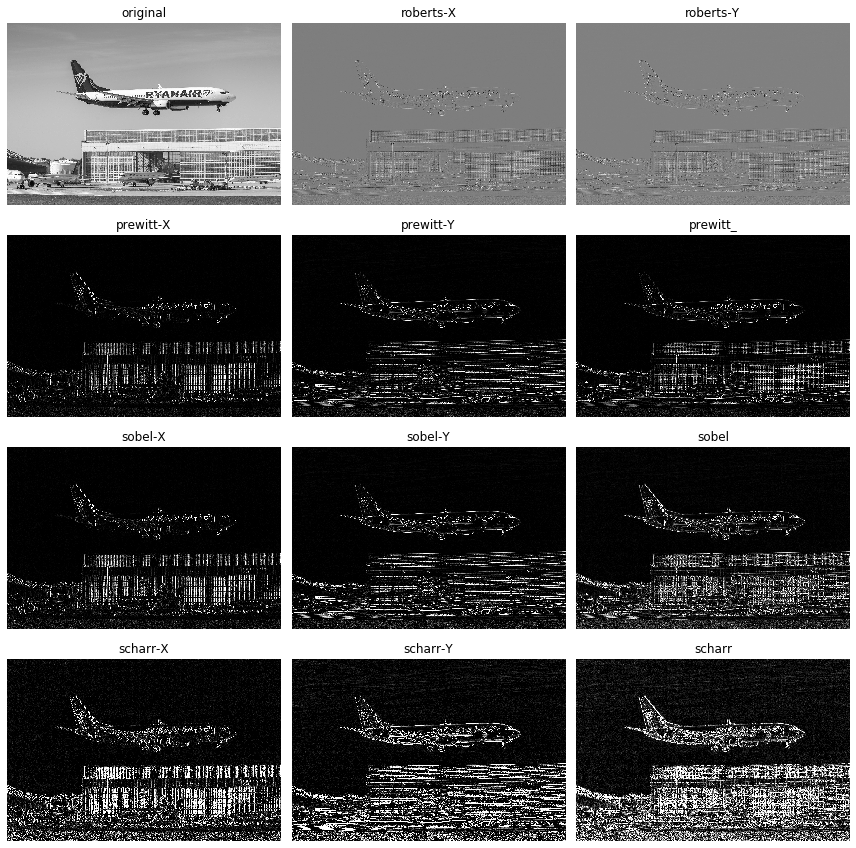

In [12]:
img = cv2.imread('ryanair-5249631_1920.jpg', cv2.IMREAD_GRAYSCALE)

robertsx = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]])
robertsy = np.array([[0, 0, -1], [0, 1, 0], [0, 0, 0]])

robertsX = cv2.filter2D(img, cv2.CV_64F, robertsx)
robertsY = cv2.filter2D(img, cv2.CV_64F, robertsy)

prewittx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitty = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
prewitt_ = np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]])

prewittX = cv2.filter2D(img, -1, prewittx)
prewittY = cv2.filter2D(img, -1, prewitty)
prewitt_ = cv2.filter2D(img, -1, prewitt_)

sobelX = cv2.Sobel(img, -1, 1, 0, ksize=3)
sobelY = cv2.Sobel(img, -1, 0, 1, ksize=3)
sobel = sobelX + sobelY

scharrX = cv2.Sobel(img, -1, 1, 0, ksize = cv2.FILTER_SCHARR)
scharrY = cv2.Sobel(img, -1, 0, 1, ksize = -1)
scharr = scharrX + scharrY

titles = ['original', 'roberts-X', 'roberts-Y', 'prewitt-X', 'prewitt-Y', 'prewitt_', 'sobel-X', 'sobel-Y', 'sobel', 'scharr-X', 'scharr-Y', 'scharr']
images = [img, robertsX, robertsY, prewittX, prewittY, prewitt_, sobelX, sobelY, sobel, scharrX, scharrY, scharr]

cv2.imshow('original', img)
cv2.imshow('Prewitt', prewitt_)
cv2.imshow('Sobel', sobel)
cv2.imshow('Scharr', scharr)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(figsize = (12, 12))
for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

    Roberts Filter의 경우 Sobel, Prewitt Filter보다 매우 빠른 계산 속도를 제공하면서 경계선 역시 확실하게 추출할 수 있다. 하지만 위의 두 필터와는 다르게 경계선이 훨씬 가늘게 나타나며 잡음에 매우 민감하게 반응하여, 잡음이 많은 이미지의 경우에는 경계선이 잘 추출되지 않을 수도 있다.   
   
    Prewitt Filter의 경우 convolution(합성곱)한 결과 Sobel Filter의 경우와 비슷하며 응답시간이 다소 빠르다. 하지만 Sobel Filter에 비해 중심화소의 차분을 동일하게 두었으므로 대각선 방향 경계선보다 수평, 수직 방향의 경게선에서 더 민감하게 반응하며, 또한 Sobel Filter보다 경계선이 덜 부각된다.
    
    Sobel Filter의 경우 Prewitt Filter과는 다르게 중심화소의 차분에 대한 비중을 2배로 키웠기 때문에 해당 필터는 Prewitt 보다 수평, 수직 방향의 경계선은 물론 대각선 방향의 경계선 역시 잘 추출한다. 필터의 크기가 커지면 커질수록 경계선이 두꺼워져서 선명하게 나타난다. 하지만 명암값의 변화 구간이 촘촘하거나 복잡한 영상일 수록 효과가 낮아진다.
    
    Scharr Filter는 Sobel Filter의 단점을 보안하기 위해 나타난 필터이다. Sobel Filter의 경우 중심에서 멀어질 수록 경계선에 대한 방향성의 정확도가 떨어지는 단점을 보안한다.

    ★ 한가지 주의할 점!
    경계선을 탐색할 때 인자로 입력되는 데이터 타입이나 출력되는 데이터 타입은 결과물에 영향을 미치는 요소이다. 예를들어 Sobel 알고리즘은 검정색에서 흰색으로 변화될 때 양수 값을 취하고, 흰색에서 검은색으로 변화될 때는 음수 값을 취한다. 만약 데이터 타입을 양수만 취급하는 np.uint8 혹은 cv2.CV_8U로 지정하게 되면 흰색에서 검은색으로 변화될 때 취한 음수값을 모두 0으로 만들어버린다. 즉 흰색에서 검은색으로의 경계를 찾이 못하게 되는 결과를 가져온다.

In [13]:
def onChange(x):
    pass

def edge_detection1():
    img = cv2.imread('ryanair-5249631_1920.jpg', cv2.IMREAD_GRAYSCALE)
    cv2.namedWindow('edge detection', cv2.WINDOW_FREERATIO)
    cv2.createTrackbar('mode', 'edge detection', 0, 4, onChange)
    cv2.imshow('edge detection', img)
    
    while True:
        k = cv2.waitKey(0) & 0xFF
        
        if k == 27:
            break
        
        mode = cv2.getTrackbarPos('mode', 'edge detection')
        
        if mode == 0:
            cv2.imshow('edge detection', img)
            
        elif mode == 1:
            robertsx = np.array([[-1, 0], [0, 1]])
            robertsy = np.array([[0, -1], [1, 0]])
            robertsX = cv2.filter2D(img, cv2.CV_64F, robertsx)
            robertsY = cv2.filter2D(img, cv2.CV_64F, robertsy)
            roberts = robertsX + robertsY
            cv2.imshow('edge detection', roberts)
            
        elif mode == 2:
            prewittx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
            prewitty = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
            prewitt_ = np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]])
            prewittX = cv2.filter2D(img, -1, prewittx)
            prewittY = cv2.filter2D(img, -1, prewitty)
            prewitt_ = cv2.filter2D(img, -1, prewitt_)
            cv2.imshow('edge detection', prewitt_)
            
        elif mode == 3:
            sobelX = cv2.Sobel(img, -1, 1, 0, ksize=3)
            sobelY = cv2.Sobel(img, -1, 0, 1, ksize=3)
            sobel = sobelX + sobelY
            cv2.imshow('edge detection', sobel)
            
        elif mode == 4:
            scharrX = cv2.Sobel(img, -1, 1, 0, ksize = cv2.FILTER_SCHARR)
            scharrY = cv2.Sobel(img, -1, 0, 1, ksize = -1)
            scharr = scharrX + scharrY
            cv2.imshow('edge detection', scharr)

            
    cv2.destroyAllWindows()

In [14]:
edge_detection1()

---
# 2. Laplacian Filter
    앞서 봤던 Sobel, Scharr, Prewitt, Roberts Filter는 이미지의 가로와 세로에 대한 Gradient를 1차 미분한 값이라면 Laplacian Filter은 Gradient를 2차 미분하여 원본 이미지와 Convolution(합성곱)하기 위한 필터이다. 1차 미분값의 크기는 주로 이미지에서 경계선(edge)의 존재여부를 알기 위해 사용할 수 있는 반면 2차 미분값의 부호는 경계선의 화소가 밝은 부분에 있는지 어두운 부분에 있는지 결정하는데 사용된다. 또한 2차 미분 방식을 사용하여 이미지를 처리하면 저주파 성분에 해당하는 값들은 소거가 되는 반면 이미지의 고주파 성분들은 더 선명하게 나타나므로 경계선 부분을 강조하여 나타낼 수 있다. 마찬가지로 이미지는 연속적인 값이 아니기 때문에 수학적으로 미분이 불가능하므로 2차 미분 역시 다음과 같은 방법으로 근사하여 계산한다.
    
    G_x = f(x+1, y) - f(x, y), dx = 1
    G_x2 = [f(x+1, y) - f(x, y)] - [f(x, y) - f(x-1, y)] = f(x+1, y) + f(x-1, y) - 2f(x, y), dx = 2
    G_y = f(x, y+1) - f(x, y), dx = 1
    G_y2 = [f(x, y+1) - f(x, y)] - [f(x, y) - f(x, y-1)] = f(x, y+1) + f(x, y-1) - 2f(x, y), dy = 2
    
    만약 f를 2차원 영상이라고 할 경우, 이 영상에 대한 이차 미분 함수는 x축과 y축에 대한 이차 미분을 수행하고, 각 방향에 대한 이차 미분 결과를 합하여 구할 수 있다. (즉 x방향 편미분 결과와 y방향으로 편미분한 결과를 더한 것과 같다.)
    delta^2f = G_x2 + G_y2 = [f(x+1, y) + f(x-1, y) + f(x, y+1) + f(x, y-1)] - 4f(x, y)
    
    Laplacian Filter   =   [ 0,  1, 0 ]    |    [ 1,  1, 1 ]
                           [ 1, -4, 1 ]    |    [ 1, -8, 1 ]
                           [ 0,  1, 0 ]    |    [ 1,  1, 1 ]
                           
    전자의 필터는 위의 앞서 구한 delta_2f의 수식을 완벽히 만족시키는 필터이다. 후자의 필터는 함수 f를 x축, y축 뿐만 아니라 양 사선으로 모두 미분 연산을 수행할 경우를 나타내는 필터이다. laplacian 함수는 전자의 필터를 default로 사용하고 있으며 ksize를 어떻게 지정하느냐에 따라 필터의 크기를 키울 수 있고, ksize의 크기를 키우면 키울수록 밝기 변화에 민감해져 복잡한 무늬를 정교하게 필터링한다.

## cv2.Laplacian(src, ddepth [, dst [, ksize [, scale [, delta [, borderType]]]]]) → dst
    1. src : 원본 이미지
    2. ddepth : 출력 이미지의 데이터 형태. -1이면 입력 이미지와 동일한 데이터 형태로 출력된다.    
    3. ksize : 커널 크기, 31 이하의 홀수만 가능하다.
    
    ksize는 defalut로 1로 정해져 있으며 ksize == 1일 경우에는 전자의 필터가 적용된다. ksize == 3일 경우에는 후자의 필터가 적용된다. 이보다 더 큰 수를 적용하면 필터의 크기 자체가 커지게 된다. 
    
    Laplacian 필터는 워낙 잡음에 민감하기 때문에 보통은 단독으로 사용하지 않고 이미지를 먼저 Gaussian Filtering으로 이미지의 노이즈를 줄인 다음에 Laplacian 필터를 사용하여 경계선을 검출하는 Laplacian of Gaussian(LoG) 방법을 많이 사용한다. 가우시안 필터링에 기반한 엣지 검출 방식이기 때문에 이미지에서의 잡음을 줄이면서 잡음에 의해 잘못 검출되는 경계선의 수를 줄이고 경계선의 굵기를 더 넓게 만들 수 있다.

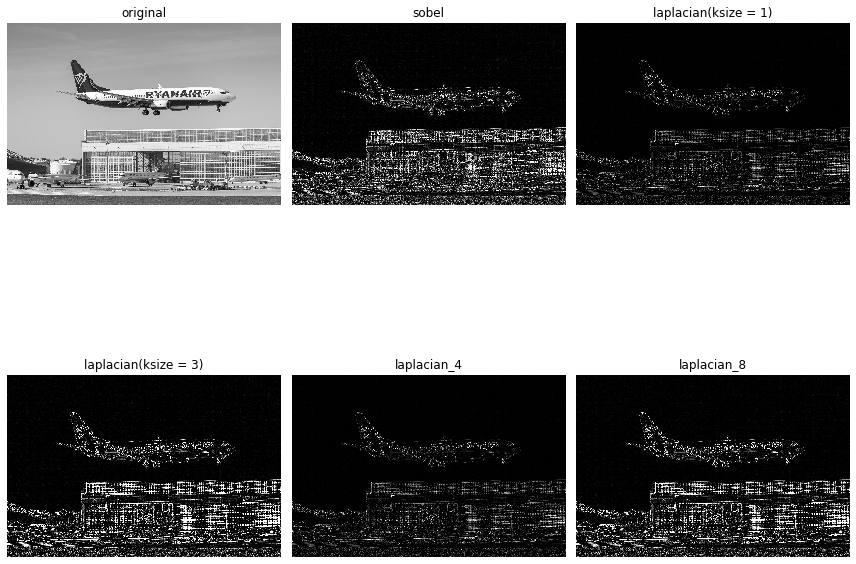

In [17]:
img2 = cv2.imread('ryanair-5249631_1920.jpg', cv2.IMREAD_GRAYSCALE)

laplacian1 = cv2.Laplacian(img2, -1)
laplacian3 = cv2.Laplacian(img2, -1, ksize = 3)

# numpy 행렬로 만든 laplacian Filter
laplacian_filter1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
laplacian_filter2 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
laplacian_4 = cv2.filter2D(img2, -1, laplacian_filter1)
laplacian_8 = cv2.filter2D(img2, -1, laplacian_filter2)

# Sobel Filter로 2번 미분
sobelX = cv2.Sobel(img, -1, 2, 0, ksize=3)
sobelY = cv2.Sobel(img, -1, 0, 2, ksize=3)
sobel = sobelX + sobelY

cv2.imshow('Laplacian(ksize = 1)', laplacian1)
cv2.imshow('Laplacian(ksize = 3)', laplacian3)
cv2.imshow('Laplacian4', laplacian_4)
cv2.imshow('Laplacian8', laplacian_8)
cv2.waitKey(0)
cv2.destroyAllWindows()

images = [img2, sobel, laplacian1, laplacian3, laplacian_4, laplacian_8]
titles = ['original', 'sobel', 'laplacian(ksize = 1)', 'laplacian(ksize = 3)', 'laplacian_4', 'laplacian_8']

plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.title(titles[i])
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
def onChange(x):
    pass

def edge_detection2():
    img = cv2.imread('ryanair-5249631_1920.jpg', cv2.IMREAD_GRAYSCALE)
    cv2.namedWindow('edge detection', cv2.WINDOW_FREERATIO)
    cv2.createTrackbar('mode', 'edge detection', 0, 5, onChange)
    cv2.imshow('edge detection', img)
    
    while True:
        k = cv2.waitKey(0) & 0xFF
        
        if k == 27:
            break
        
        mode = cv2.getTrackbarPos('mode', 'edge detection')
        
        if mode == 0:
            cv2.imshow('edge detection', img)
            
        elif mode == 1:
            sobelX = cv2.Sobel(img, -1, 2, 0, ksize=3)
            sobelY = cv2.Sobel(img, -1, 0, 2, ksize=3)
            sobel = sobelX + sobelY
            cv2.imshow('edge detection', sobel)
            
        elif mode == 2:
            laplacian1 = cv2.Laplacian(img, -1)
            cv2.imshow('edge detection', laplacian1)
            
        elif mode == 3:
            laplacian3 = cv2.Laplacian(img, -1, ksize=3)
            cv2.imshow('edge detection', laplacian3)
            
        elif mode == 4:
            laplacian_filter1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
            laplacian_4 = cv2.filter2D(img2, -1, laplacian_filter1)
            cv2.imshow('edge detection', laplacian_4)
            
        elif mode == 5:
            laplacian_filter2 = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]])
            laplacian_8 = cv2.filter2D(img2, -1, laplacian_filter2)
            cv2.imshow('edge detection', laplacian_8)
            
    cv2.destroyAllWindows()

In [28]:
edge_detection2()